In [2]:
import networkx as nx
import pandas as pd
#from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
#from collections import Counter
#import seaborn as sns
#import sys
#import os
from relevant_functions import Granover_methods as GM
# from Granovetter_experiment_results import (
#     #function draws treshold values for each node in G, 
#     #mode determines how treshold values are generated
#     #each node samples tershold from specified distribution
#     #phi mean and phistd control mean and stdv of distribution
#     #inputs = G, mode, phi_mean, phi_std
#     draw_thresholds, 
#     #simulates treshold dynamics on graph G
#     #input = G, list of seeds, dict of tresholds, max_nr_steps 
#     #returns dictionary with time series of adopted nodes and numpy array
#     # of adopted nodes over time (history)
#     threshold_dynamics,
#     #input = adopted nodes
#     final_adoption_fraction,
#     #function to calculate the time to reach a target fraction of adopted nodes
#     #inputs = history, target=0.5)
#     time_to_fraction,
#     #random seeds
#     random_seeds,
#     #select top-B nodes with highest degree in graph G
#     high_degree_seeds,
#     #does same as for degree, uses a list comprehension and a lambda function
#     #lambda function takes tuple x = (node,betweenness_value) and returns the second
#     # value b which is the betweenness centrality(x[1]) in descending order
#     # [:B] takes the first B entries from the sorted list, which are the nodes with the highest betweenness centrality.
#     #inputs = G, B
#     betweenness_seeds,
#     #this funciton seeds the network with B nodes with highest core centrality nunmber,
#     # core nr is nr of nodes that are connected to all its neighbors
#     # for given graph G, the core number of a node v is the largest value k such that v is in a k-core.
#     #other words: tells you how deeply embedded a node is within the network's core structure.
#     #higher core number means node is more central to the network's connectivity
#     #inputs = G, B
#     kcore_seeds,
#     #estimates the spread of the treshold dynamics on graph G
#     #it runs the treshold dynamics R times, with different random seeds and tressholds
#     #returns the average final adoption fraction
#     #input = G, seeds, B, thresholds, R=5, max_steps =100
#     estimate_spread,
    
#     run_experiments
# ) 
Random_seed = 42
random.seed(Random_seed)
np.random.seed(Random_seed)


In [3]:
#store nodes and edges data
def load_data(nodes, edges):

    nodes = pd.read_csv(nodes)
    edges = pd.read_csv(
        edges,
        header=None,
        names=["source_new_id", "target_new_id"],
    )
    # merge to get page names
    df_merged = (
        edges
        .merge(nodes[['new_id', 'name']], left_on='source_new_id', right_on='new_id')
        .rename(columns={'name': 'page_name_1'})
        .drop('new_id', axis=1)
        .merge(nodes[['new_id', 'name']], left_on='target_new_id', right_on='new_id')
        .rename(columns={'name': 'page_name_2'})
        .drop('new_id', axis=1)
        .rename(columns={
            'source_new_id': 'page_id_1',
            'target_new_id': 'page_id_2'
        })
    )
    print(nodes.size)
    print(edges.size)
    return df_merged, nodes, edges

In [10]:
#threadpullexecuter
df_merged, nodes, edges = load_data("fb-pages-public-figure.nodes", "fb-pages-public-figure.edges")

34677
134228


In [6]:
def create_facebookpage_network(df):
    """
    Create a network graph from Facebook page data.
    
    Args:
        df (pandas.DataFrame): Facebook page data
        
    Returns:
        networkx.Graph: Undirected graph of Facebook page connections
    """
    print("Creating Facebook page network...")
    
    # Create undirected graph (dataset shows pages in bidirectional connections)
    G = nx.Graph()
    
    # Add edges for each route
    for _, row in df.iterrows():
        source = row['page_name_1']
        dest = row['page_name_2']

        # Skip self-loops
        if source != dest:
            if G.has_edge(source, dest):
                # Increment weight if edge already exists
                G[source][dest]['weight'] += 1
            else:
                # Add new edge with weight 1
                G.add_edge(source, dest, weight=1)

    print(f"Network created with {G.number_of_nodes()} facebook pages and {G.number_of_edges()} connections")

    return G

In [7]:
G = create_facebookpage_network(df_merged)

Creating Facebook page network...
Network created with 11534 facebook pages and 66942 connections


In [ ]:
#Granovetterstyle threshold dynamics
#idea is you have 2 states, 0 and 1. based on when you update node, 
# based on neighbors, if two nodes are from the opposite category, 
# next time step it will stay same if treshold is met, 
# it will change if treshold is not met?
#normalized
#
# explore how the structure of your network affects the spread of behaviour or information under
#different seeding strategies.



#implement 1
#either treshold will be the same for all nodes 
#or treshold will be different for different nodes, draf from a distribution
#

#compare seeding strategies:
#investigate different seeding strategies such as random seeding nodes, 
# targeting high-degree nodes, or targeting nodes based on their 
# centrality measures (is that same as highest-betweenness nodes?).
#seeding strategies (random, high-degree, high-betweenness, k-core)
seeding_strategies = ['random', 'high-degree', 'high-betweenness', 'k-core']


#for each strategy, record and compare:
#- final fraction of active nodes (so state 1?)
# nr of time steps until steady state is reached (or 100% adoption)
# shape of the adoption curve over time


#choose and document:
#Network used (from assignment 2, what is this?)
# nr of seeds (1%, 5% )?
nr_of_seeds = [0.01, 0.05, 0.1]
#treshold values (fixed or distributed)
threshold_distributions = {'beta','fixed', 'uniform', 'normal'}
#number of simulation repititions (30?) to reduce stochastic effects

#with notebook in for loop add something that shows how far in the process you are (how many percent done)

In [45]:
#define parameters for simulation
#nr of nodes
n = G.number_of_nodes()
#choose treshold distribution as beta because of characteristics 
#of this facebook network, because of its heavy-tailed degree distribution
# and presence of highly connected hubs, which can significantly influence
#the spread of information. The beta distribution allows for flexibility in modeling
#varied adoption thresholds among nodes, capturing the heterogeneity in user behavior
#on social media platforms. This choice helps in realistically simulating how information
#spreads through the network, accounting for both early adopters and more resistant nodes.
treshold_distribution = 'beta'

#seed fractions 0.01 and 0.05 to see difference in spread
# 1% vs 5% will reveal strategy differences
seed_fractions = [0.01,0.03,0.05]

#Because I have a large graph and not a fast laptop I choose 10 repetitions
#per experiment
R = 10

#To save time, choose 100 as max steps, let's see if this is enough for convergence 
max_steps = 100


#take treshold values for each node in G based on treshold distribution
treshold_values_fb = GM.draw_thresholds(G, mode=treshold_distribution, phi_mean=0.3, phi_std=0.1)


In [21]:
#compute betweenness approximation to save time
#k = 300 because that gives the best trade-off between accuracy and computation time
# for a graph of this size (11k nodes)
betweenness_approx = nx.betweenness_centrality(G, k=300, seed=42)
#save it so i can use it later
np.save('betweenness_approx_fb.npy', betweenness_approx)


KeyboardInterrupt: 

In [46]:
#load precomputed betweenness approximation
betweenness_approx = np.load('betweenness_approx_fb.npy', allow_pickle=True).item()


In [47]:
#redefine betweenness seeds function to use precomputed betweenness
def betweenness_seeds_precomputed(G, B,betweenness):
     return sorted(betweenness, key=betweenness.get, reverse=True)[:B]



In [48]:

#draw tresholds for each node in G based on treshold distribution
tresholds = GM.draw_thresholds(G, mode=treshold_distribution, phi_mean=0.3, phi_std=0.1)


In [49]:
#k-core not required and greedy takes too much time
strategies = {
    "Random": lambda B: GM.random_seeds(G, B),
    "Degree": lambda B: GM.high_degree_seeds(G, B),
    "Betweenness": lambda B: betweenness_seeds_precomputed(G, B, betweenness_approx)
}

In [50]:
results = []

In [51]:
for seed in seed_fractions:
    B = int(seed * n)  #number of seeds based on fraction
    print(f"Running simulations for seed fraction: {seed} ({B} seeds)")
    
    for strategy_name, seeds_strategy in strategies.items():
        print(f"  Strategy: {strategy_name}")

        #degree and betweenness use precomputed values
        #for random we get new seeds each repetition
        for r in range(R):
            # pick seeds
            seeds = seeds_strategy(B)

            #run threshold dynamics
            adopted_seeds, history = GM.threshold_dynamics(G, seeds, tresholds, max_steps=max_steps)

            #metrics
            final_adopted = GM.final_adoption_fraction(adopted_seeds)
            time_to_50 = GM.time_to_fraction(history, target=0.5)

            results.append({
                "Seed_Fraction": seed,
                "Strategy": strategy_name,
                "Repetition": r + 1,
                "B": B,
                "Final_Adoption_Fraction": final_adopted,
                "Time_to_50%_Adoption": time_to_50,
                "history": history
            })
#store results in dataframe
results_df = pd.DataFrame(results)
        

Running simulations for seed fraction: 0.01 (115 seeds)
  Strategy: Random
  Strategy: Degree
  Strategy: Betweenness
Running simulations for seed fraction: 0.03 (346 seeds)
  Strategy: Random
  Strategy: Degree
  Strategy: Betweenness
Running simulations for seed fraction: 0.05 (576 seeds)
  Strategy: Random
  Strategy: Degree
  Strategy: Betweenness


In [52]:
results_df.head()

,Seed_Fraction,Strategy,Repetition,B,Final_Adoption_Fraction,Time_to_50%_Adoption,history
0,0.01,Random,1,115,0.980579,12.0,"[0.009970521935148257, 0.027050459511010923, 0..."
1,0.01,Random,2,115,0.970782,15.0,"[0.009970521935148257, 0.021588347494364488, 0..."
2,0.01,Random,3,115,0.978932,12.0,"[0.009970521935148257, 0.024536153979538754, 0..."
3,0.01,Random,4,115,0.971042,12.0,"[0.009970521935148257, 0.02609675741286631, 0...."
4,0.01,Random,5,115,0.971389,16.0,"[0.009970521935148257, 0.021761747875845328, 0..."


In [ ]:
#It calculates B, the number of initial adopters.

# For each seeding strategy (Random, Degree, Betweenness):

# It runs R independent simulations of the threshold dynamics.

# In each simulation it:

# selects seeds according to the strategy

# simulates adoption over time

# measures the final outcome

# measures how fast adoption spreads

# stores the full adoption curve

# This gives you a complete picture of:

# how far cascades propagate (final adoption)

# how fast they propagate (time to 50% adoption)

# the shape of the adoption dynamics (history)

# how results differ across strategies and seed sizes

# This is exactly what your assignment requires.

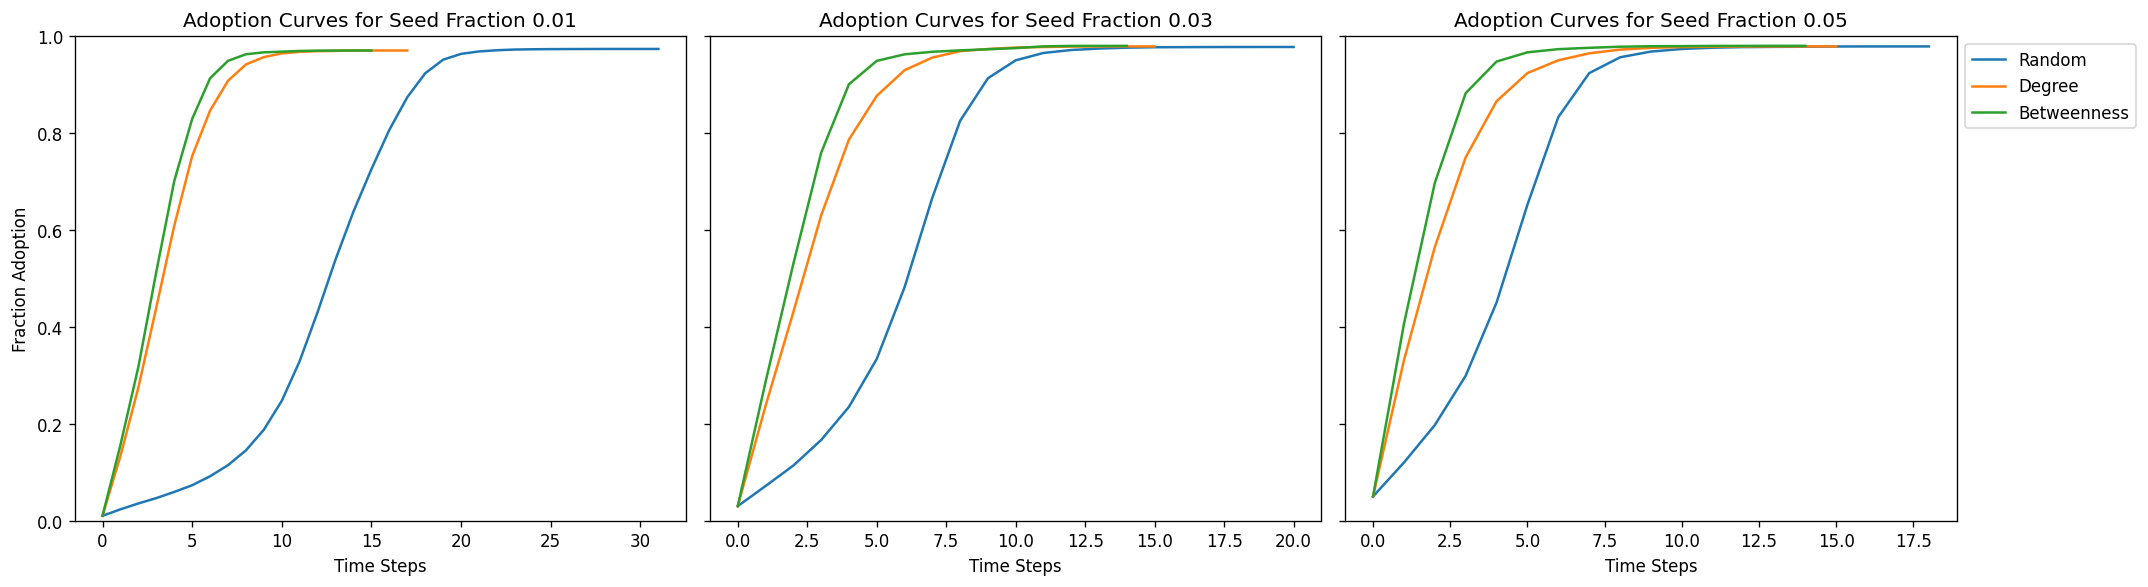

In [53]:
#let's plot the adoption curves for each strategy and seed fraction
#plt.figure(figsize=(12, 8))
fig, axes = plt.subplots(1, len(seed_fractions), figsize=(18, 5), sharey=True)

strategie_order = ["Random", "Degree", "Betweenness"]
for idx, seed_frac_plot in enumerate(seed_fractions):
    subset = results_df[results_df['Seed_Fraction'] == seed_frac_plot]
    ax = axes[idx]

    for strategy_name in strategie_order:
        strategy_data = subset[subset['Strategy'] == strategy_name]
        #average history over repetitions
        histories = strategy_data['history'].tolist()

        if len(histories) == 0:
            continue
        max_length = max(len(h) for h in histories)
        #lengths histories the same
        padded_histories = []
        for h in histories:
            if len(h) < max_length:
                pad_val = h[-1]
                extra = np.full((max_length - len(h),), pad_val)
                h = np.concatenate((h, extra))
            padded_histories.append(h)
        mean_history = np.mean(padded_histories, axis=0)
        ax.plot(range(max_length), mean_history, label=strategy_name)
    ax.set_title(f'Adoption Curves for Seed Fraction {seed_frac_plot}')
    ax.set_ylim(0, 1)
    ax.set_xlabel('Time Steps')
axes[0].set_ylabel('Fraction Adoption')
axes[-1].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

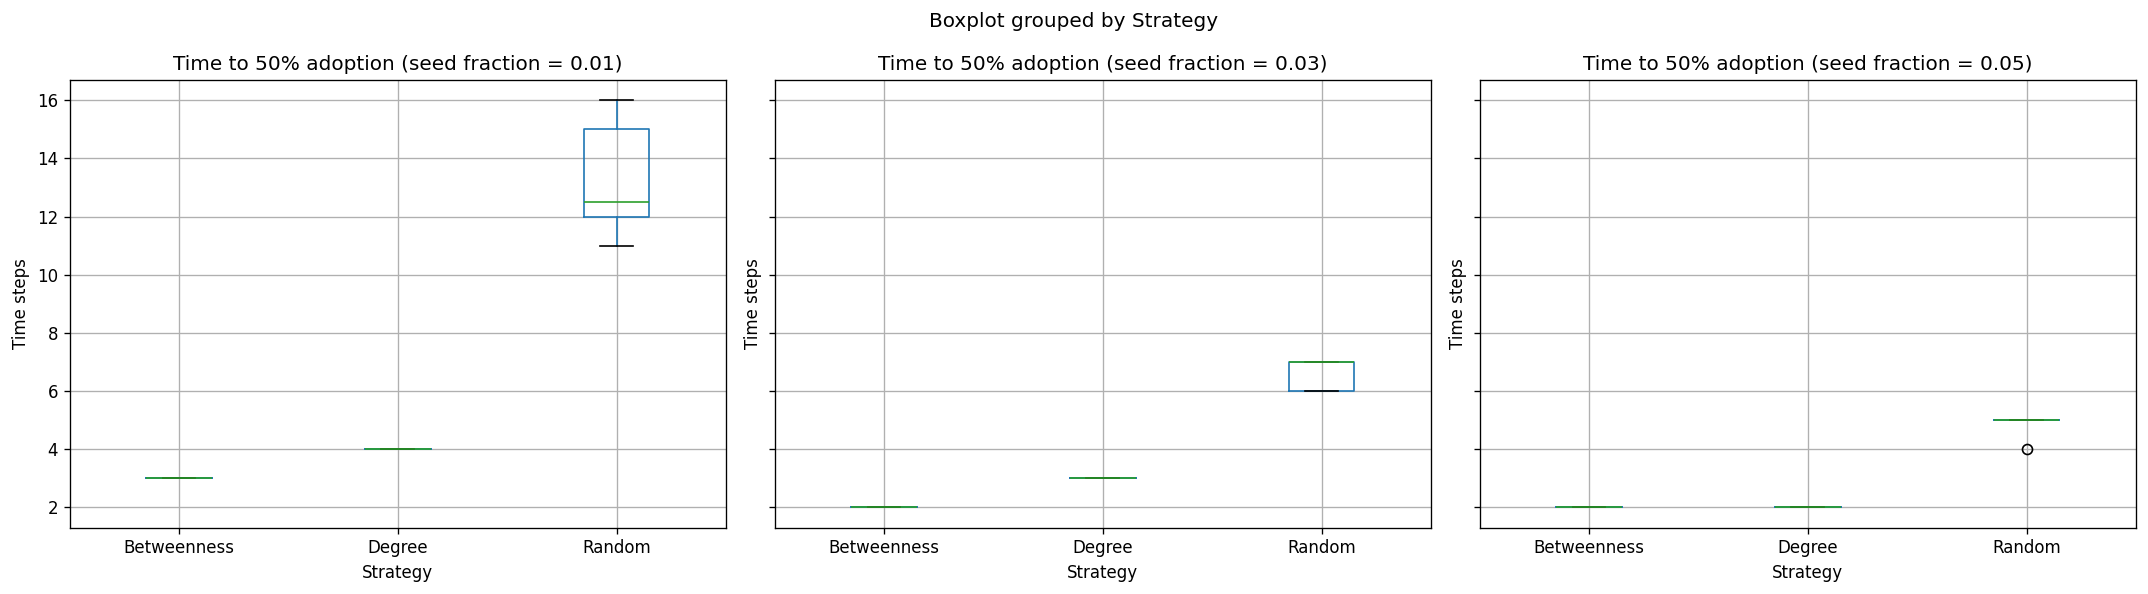

In [58]:
fig, axes = plt.subplots(1, len(seed_fractions), figsize=(18, 5), sharey=True)
for idx, seed_frac_to_plot in enumerate(seed_fractions):
    subset = results_df[results_df["Seed_Fraction"] == seed_frac_to_plot]

    subset.boxplot(column="Time_to_50%_Adoption", by="Strategy", ax=axes[idx])
    axes[idx].set_title(f"Time to 50% adoption (seed fraction = {seed_frac_to_plot})")
    axes[idx].set_ylabel("Time steps")
    axes[idx].set_xlabel("Strategy")
    axes[idx].set_ylabel("Time steps")
plt.tight_layout()
plt.show()

In [9]:

from relevant_functions import Granover_methods as GM
from Granovetter_experiment_results import (
    #function draws treshold values for each node in G, 
    #mode determines how treshold values are generated
    #each node samples tershold from specified distribution
    #phi mean and phistd control mean and stdv of distribution
    #inputs = G, mode, phi_mean, phi_std
    draw_thresholds, 
    #simulates treshold dynamics on graph G
    #input = G, list of seeds, dict of tresholds, max_nr_steps 
    #returns dictionary with time series of adopted nodes and numpy array
    # of adopted nodes over time (history)
    threshold_dynamics,
    #input = adopted nodes
    final_adoption_fraction,
    #function to calculate the time to reach a target fraction of adopted nodes
    #inputs = history, target=0.5)
    time_to_fraction,
    #random seeds
    random_seeds,
    #select top-B nodes with highest degree in graph G
    high_degree_seeds,
    #does same as for degree, uses a list comprehension and a lambda function
    #lambda function takes tuple x = (node,betweenness_value) and returns the second
    # value b which is the betweenness centrality(x[1]) in descending order
    # [:B] takes the first B entries from the sorted list, which are the nodes with the highest betweenness centrality.
    #inputs = G, B
    betweenness_seeds,
    #this funciton seeds the network with B nodes with highest core centrality nunmber,
    # core nr is nr of nodes that are connected to all its neighbors
    # for given graph G, the core number of a node v is the largest value k such that v is in a k-core.
    #other words: tells you how deeply embedded a node is within the network's core structure.
    #higher core number means node is more central to the network's connectivity
    #inputs = G, B
    kcore_seeds,
    #estimates the spread of the treshold dynamics on graph G
    #it runs the treshold dynamics R times, with different random seeds and tressholds
    #returns the average final adoption fraction
    #input = G, seeds, B, thresholds, R=5, max_steps =100
    estimate_spread,
    
    run_experiments
) 

Packages loaded.
N=300, k_avg=6, B=5, ENSEMBLES=10, RUNS_PER_SETTING=15
ER threshold mean: 0.276
WS threshold mean: 0.298
BA threshold mean: 0.28


KeyboardInterrupt: 

In [ ]:
# df_results = run_experiments(
#     N=N,
#     k_avg=k_avg,
#     ensembles=ENSEMBLES,
#     runs_per_setting=RUNS_PER_SETTING,
#     threshold_mode=THRESHOLD_MODE,
#     phi_mean=PHI_MEAN,
#     phi_std=PHI_STD,
#     B=B,
#     max_steps=MAX_STEPS,
#     greedy_R=GREEDY_R
# )
# df_results.head()

In [ ]:
#B_initial = []
#N = 300 (what is N?)
ensembles = [5,10,15]
runs_per_simulationrun = [10,20,30]
max_steps = [100,200,300]

